In [1]:
#!pip uninstall huetracer -y
#!pip install huetracer
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns
import os
import random
import numpy as np
import pandas as pd
import scvi
import gc
import math
import bin2cell as b2c
import torch
from itertools import cycle
from sklearn.neighbors import NearestNeighbors
import importlib
import gdown
import zipfile
import adjustText as at
import scipy
import huetracer

pd.set_option('display.max_columns', None)
sc.set_figure_params(figsize=[10,10],dpi=100)

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

scvi.settings.seed = 0
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else"mps" if torch.backends.mps.is_available() else "cpu")
device_str = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")

Seed set to 0


Using device: mps


In [2]:
### parameters to be input
SAMPLE_NAME = 'FFPE9'
lib_id = SAMPLE_NAME # list(sp_adata.uns['spatial'].keys())[0]
lib_id = SAMPLE_NAME # list(sp_adata.uns['spatial'].keys())[0]

path = os.path.expanduser("~")+"/Desktop/space/GCTB_bin2cell"
save_path_for_today = os.path.expanduser("~")+"/tmp/outputs/250610_" + SAMPLE_NAME
source_image_path = "../VisiumHD/image/microscope_image/" + SAMPLE_NAME + ".tif"

### ligand-receptor data obtained from nichenet, download only once
# # 1. Google Drive link URL
# url = "https://drive.google.com/uc?export=download&id=1pMpGUfsrDNWmZ_osfSglX5MrL8e8vOeA"
# # 2. File name
# output = "ligand_target_df.csv.zip"
# # 3. Download
# gdown.download(url, output, quiet=False)
# # 4. ZIP file extraction
# with zipfile.ZipFile(output, 'r') as zip_ref:
#     zip_ref.extractall("ligand_target_df")

# 5. Set your path
file_nichenet = '../GCTB_bin2cell/data/tutorial/ligand_target_df.csv'

# area to be analyzed
# ## GCTB spatial G1, FFPE9
mask_large_x1, mask_large_x2, mask_large_y1, mask_large_y2 = 450, 1950, 250, 1750

# List of target gene names
target_genes = [
    'TNFSF11', 'LIF', 'TNFRSF11A', 'LIFR',
    'CTSK', 'CTSB', 'LMNB1', 'MEGF10',
    'MMP9', 'MMP13', 'SPP1', 'GRN',
    'NOTCH3', 'SDC2', 'TIMP1', 'SPARC',
    'ACP5'
    # Add more genes here if needed
]

annotation_dict = {
    'C0':  'Tumor',         # COL6A1, COL6A2, NOTCH3 → 間葉系様腫瘍細胞
    'C1':  'Tumor',      # DCN, PTH1R, TIMP3, TNC → 単球/間質細胞
    'C2':  'Tumor',     # PTH1R, PTPRS, ITGB3, ITGA10 → 破骨様細胞マーカー
    'C3':  'Monocyte',    # APOE, C1QC, C1QA, PSAP → マクロファージ
    'C4':  'Tumor',         # COL1A1, COL3A1, COL5A1 → 腫瘍由来間葉系様細胞
    'C5':  'Lymphocyte',    # AKNA, CORO1A, TRAC, EVL → T細胞系
    'C6':  'Monocyte',      # CCNL2, COL16A1, WSB1 → マクロファージ・単球様
    'C7':  'Endothelial',   # EGFL7, CDH5, COL4A2, PECAM1 → 血管内皮マーカー
    'C8':  'GiantCell',      # FOS, EGR1, DUSP1, COL16A1 → 活性化単球系
    'C9':  'CAFibroblast',         # MMP9, ACP5, CTSK → 腫瘍/破骨細胞由来
    'C10': 'GC_proliferating',   # EGFL7, CDH5, COL4A2 → 明確な血管内皮
    'C11': 'GiantCell',     # MMP9, VCAN, ADAMTS2 → 破骨様・巨大細胞マーカー
    'C12': 'Tumor',      # SPI1, CD74, LYZ → 単球・マクロファージマーカー
    'C13': 'Doublet',     # TCIRG1, RUFY4, EXT1, CTSK → 破骨細胞活性化系
    'C14': 'Tumor',      # STAB1, CD163, CD14 → マクロファージ/単球
    'C15': 'Doublet',     # MMP9, CKB, ACP5 → 活性化破骨様細胞
    'C16': 'Tumor',         # LMNB2, CKAP4, TYMS → 腫瘍性細胞周期・増殖
    'C17': 'Monocyte',      # PSAP, C1QC, CTSB → 貪食細胞・単球系
    'C18': 'Tumor',         # IGFBP7, ID3, ID1 → 腫瘍増殖系
    'C19': 'Tumor',    # TRAC, AKNA, CORO1A → T細胞系
    'C20': 'Monocyte',      # STAB1, SAT1, CXCR4 → マクロファージ様
    'C21': 'Tumor',          # COL1A1, ALPL, COL1A2 → 間葉系腫瘍性細胞
    'C22': 'Tumor',
    'C23': 'Tumor'
}

target_cell_type = annotation_dict['C0'] # Simply select a single cell type as cluster number
# target_cell_type = 'Airway epithelial cells (CAPN8+, ELF3+)' # 'Tumor', 'GiantCell', etc., replace with your desired CellType
# target_cell_type = "Tumor"
# target_cell_type = "GiantCell"
# target_cell_type = "GC_proliferating"

Gene_to_analyze = "LIF"
# Gene_to_analyze = "CSF1"
# Gene_to_analyze = "MFAP5"
# Gene_to_analyze = "POSTN"
# Gene_to_analyze = "VSIG10"
# Gene_to_analyze = "GRP"
# Gene_to_analyze = "MFAP5"
# Gene_to_analyze = "TNN"

# Definition of neighborhood cells
neighbor_cell_numbers = 19

#role = 'sender'
role = 'receiver'
each_display_num = 5

# Volcano plot of gene expression between clusters
group1_environments = ['0', '2'] # Microenvironmentのカテゴリ名。文字列で定義
group2_environments = ['1', '3'] # Microenvironmentのカテゴリ名。文字列で定義

# setting for filenames
label_image_filename = "he_labels_image.pdf"
h5ad_filename = SAMPLE_NAME + "_b2c.h5ad"
h5ad_full_filename = SAMPLE_NAME + "_2um.h5ad"
h5ad_predicted_full_filename = SAMPLE_NAME + "_nucleus_predicted.h5ad"
h5ad_sc_filtered_full_filename = SAMPLE_NAME + "_single_cell_filtered.h5ad"
h5ad_sc_microenvironment_full_filename = SAMPLE_NAME + "_single_cell_microenvironment.h5ad"
save_spatial_plot_path = os.path.join(save_path_for_today, "cropped_spatial_plot.svg")
save_svg_path = os.path.join(save_path_for_today, "spatial_salvage_labels.svg")
h5ad_save_path = os.path.join(save_path_for_today, h5ad_filename)
h5ad_full_save_path = os.path.join(save_path_for_today, h5ad_full_filename)
h5ad_predicted_full_save_path = os.path.join(save_path_for_today, h5ad_predicted_full_filename)
h5ad_sc_filtered_full_save_path = os.path.join(save_path_for_today, h5ad_sc_filtered_full_filename)
h5ad_microenvironment_full_save_path = os.path.join(save_path_for_today, h5ad_sc_microenvironment_full_filename)

os.chdir(path)
os.makedirs(save_path_for_today, exist_ok=True)


In [3]:
# DeepCOLOR-like analysis with NicheNet database

sp_adata_raw = sc.read_h5ad(h5ad_save_path)
sp_adata_microenvironment = sc.read_h5ad(h5ad_microenvironment_full_save_path)
lt_df_raw = pd.read_csv(file_nichenet, index_col=0)

### choose microenvironment clusters to be analyzed
cluster_label = np.unique(sp_adata_microenvironment.obs['predicted_microenvironment'])
#cluster_label = ['0', '1', '2']

sp_adata, lt_df = huetracer.prepare_microenv_data(sp_adata_raw, sp_adata_microenvironment, lt_df_raw, min_frac=0.001, n_top_genes=5000)


_logistic.py (469): lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
_highly_variable_genes.py (73): `flavor='seurat_v3'` expects raw count data, but non-integers were found.


In [4]:
# 新しいレイヤーを作成して元のデータを保持
# sp_adata.X の形状を取得
sp_adata = sp_adata.copy()
if scipy.sparse.issparse(sp_adata.X):
    sp_adata.X = sp_adata.X.toarray()
huetracer.add_zscore_layers(sp_adata, top_fraction=0.05)

mask = sp_adata.obs['cluster'].isin(cluster_label)
cluster_cells = sp_adata[mask]

top_diff_expr_genes = huetracer.make_top_values(cluster_cells.layers["zscore_by_celltype"], axis=1, top_fraction=0.05)
expr_up_by_ligands = huetracer.make_top_values(top_diff_expr_genes @ lt_df, axis=0, top_fraction=0.05).to_numpy()
ligands = lt_df.columns

edge_df, center_adata, exp_data = huetracer.construct_microenvironment_data(
    sp_adata=sp_adata,
    cluster_cells=cluster_cells,
    ligands=ligands,
    expr_up_by_ligands=expr_up_by_ligands,
    neighbor_cell_numbers=neighbor_cell_numbers
)


Microenvironment data construction...


100%|███████████████████████████████████| 77058/77058 [00:08<00:00, 8682.01it/s]
cci.py (206): Setting element `.layers['expr_up']` of view, initializing view as actual.


In [6]:
# 平均よりも1.25倍CCIが生じているligandを抽出
coexp_cc_df, bargraph_df = huetracer.calculate_coexpression_coactivity(edge_df, center_adata, exp_data, expr_up_by_ligands, role=role, up_rate = 1.25)

# save CCI data as an excel file
filename = SAMPLE_NAME + "_environment_to_center_df_cell_type_cell_1_is_" + role + ".xlsx"
out_xlsx = os.path.join(save_path_for_today, filename)
coexp_cc_df.to_excel(out_xlsx)


plot.py (16): Trying to modify attribute `.obs` of view, initializing view as actual.
plot.py (17): The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


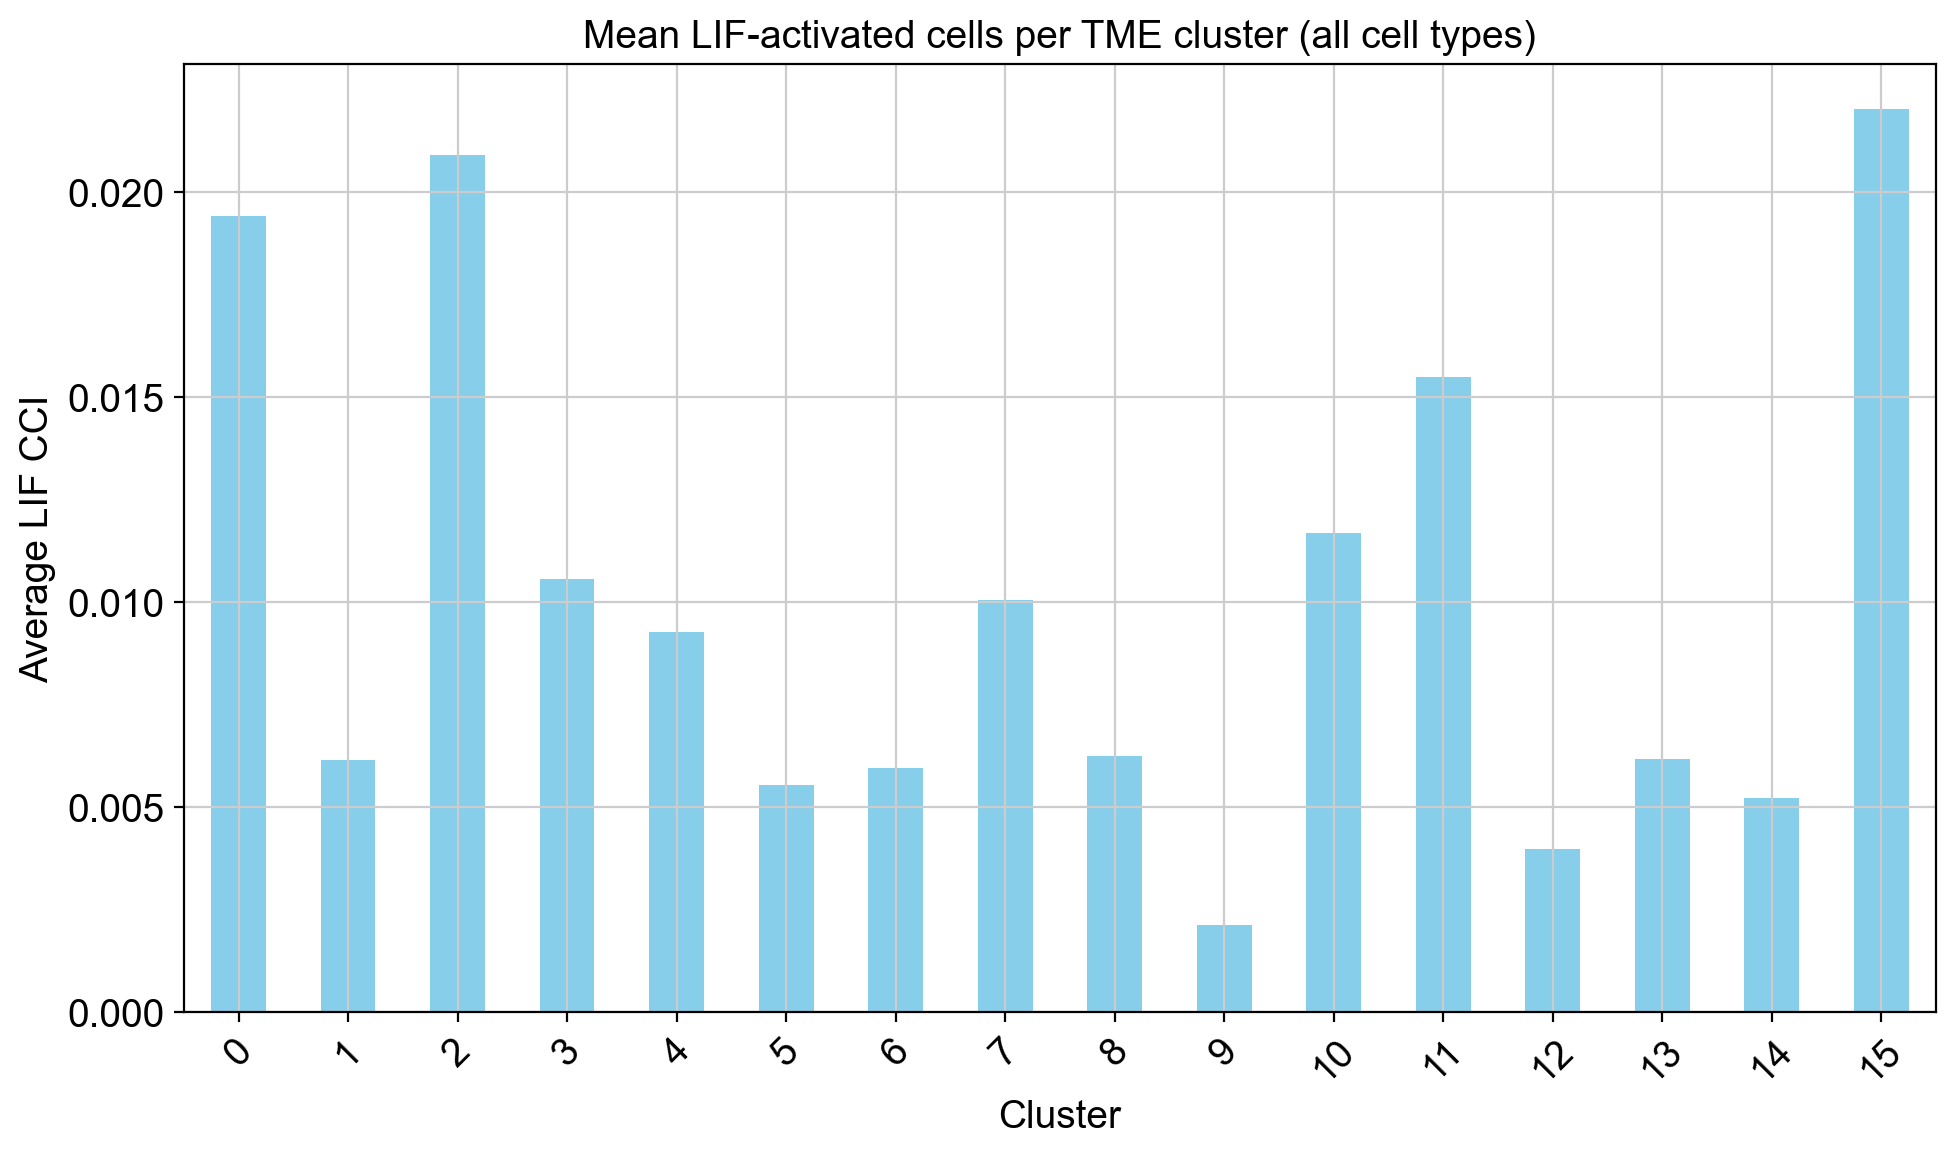

plot.py (38): The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


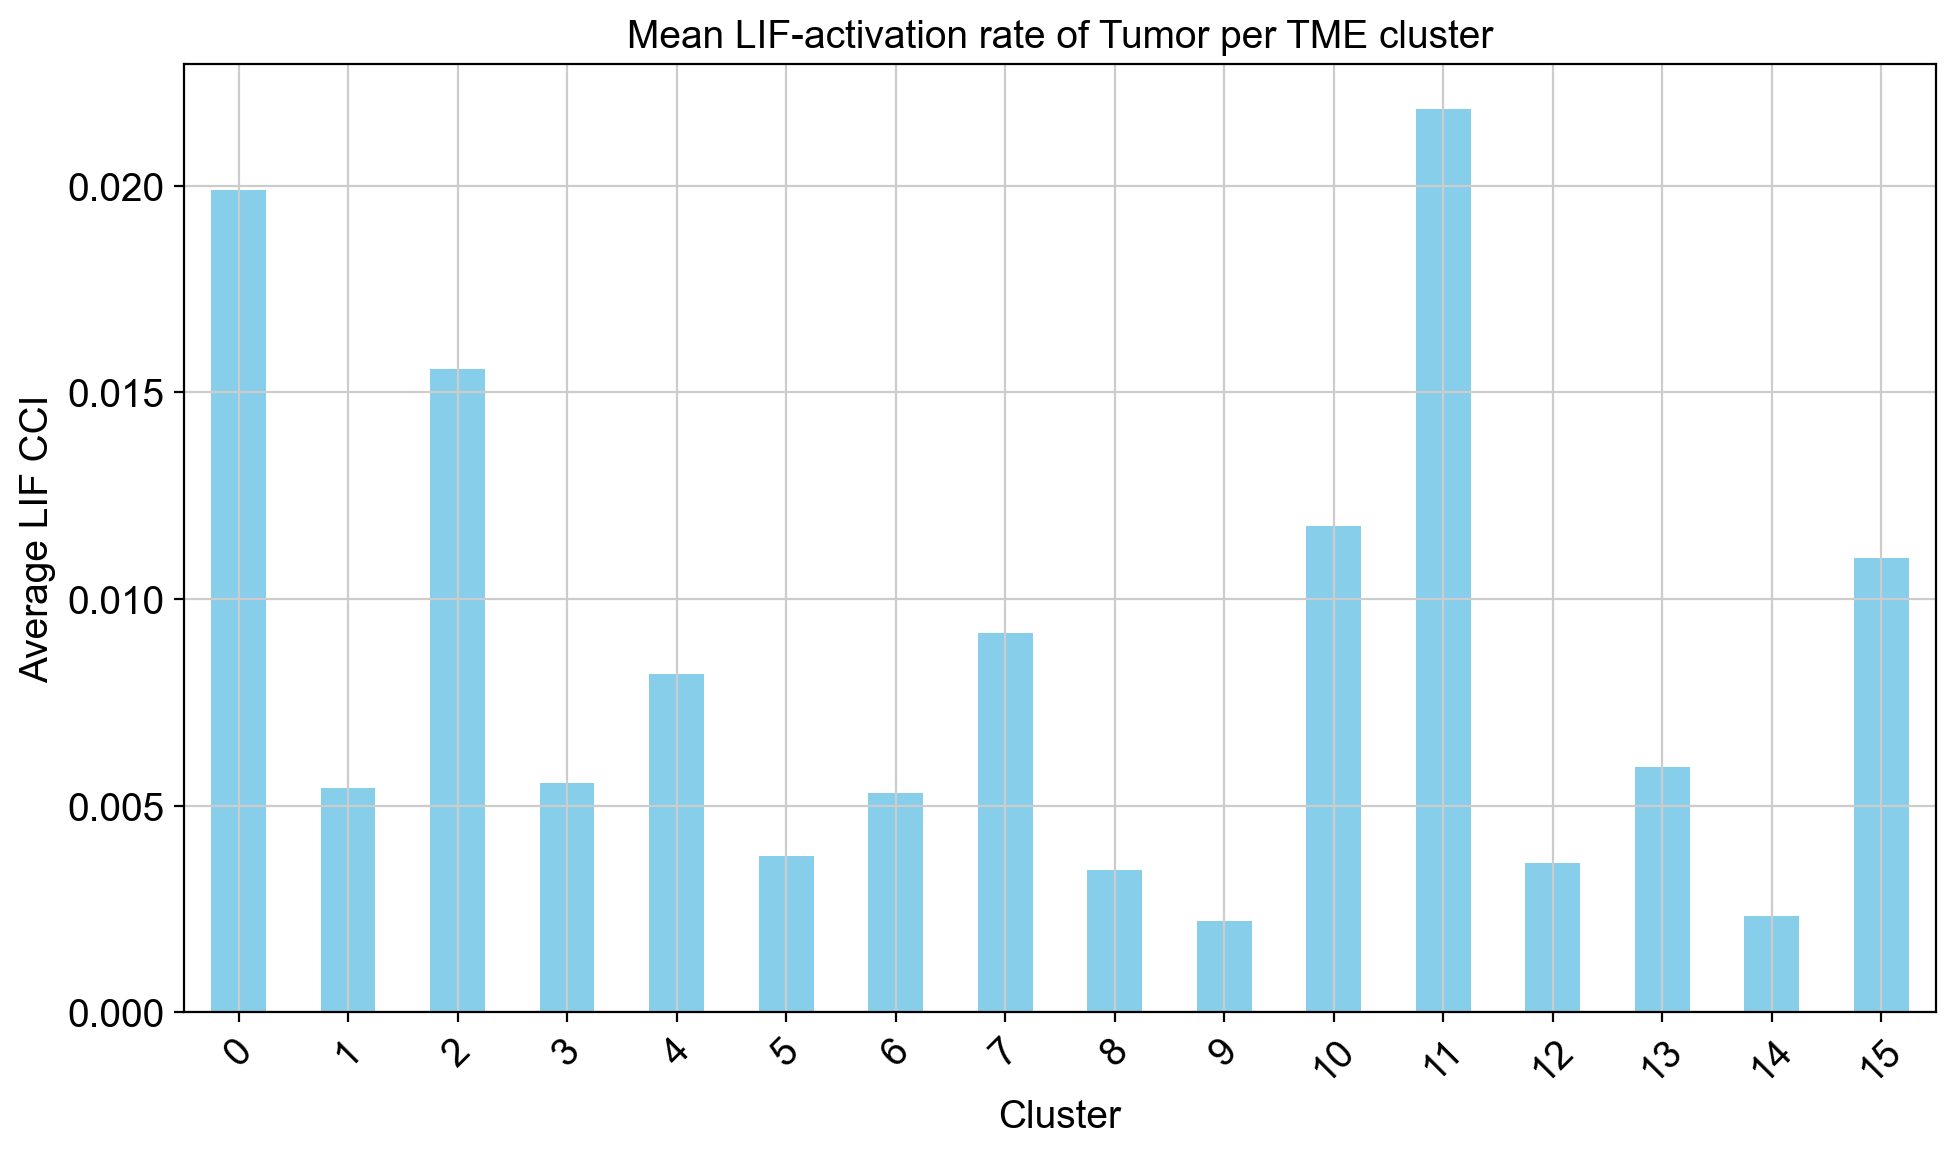

plot.py (82): This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


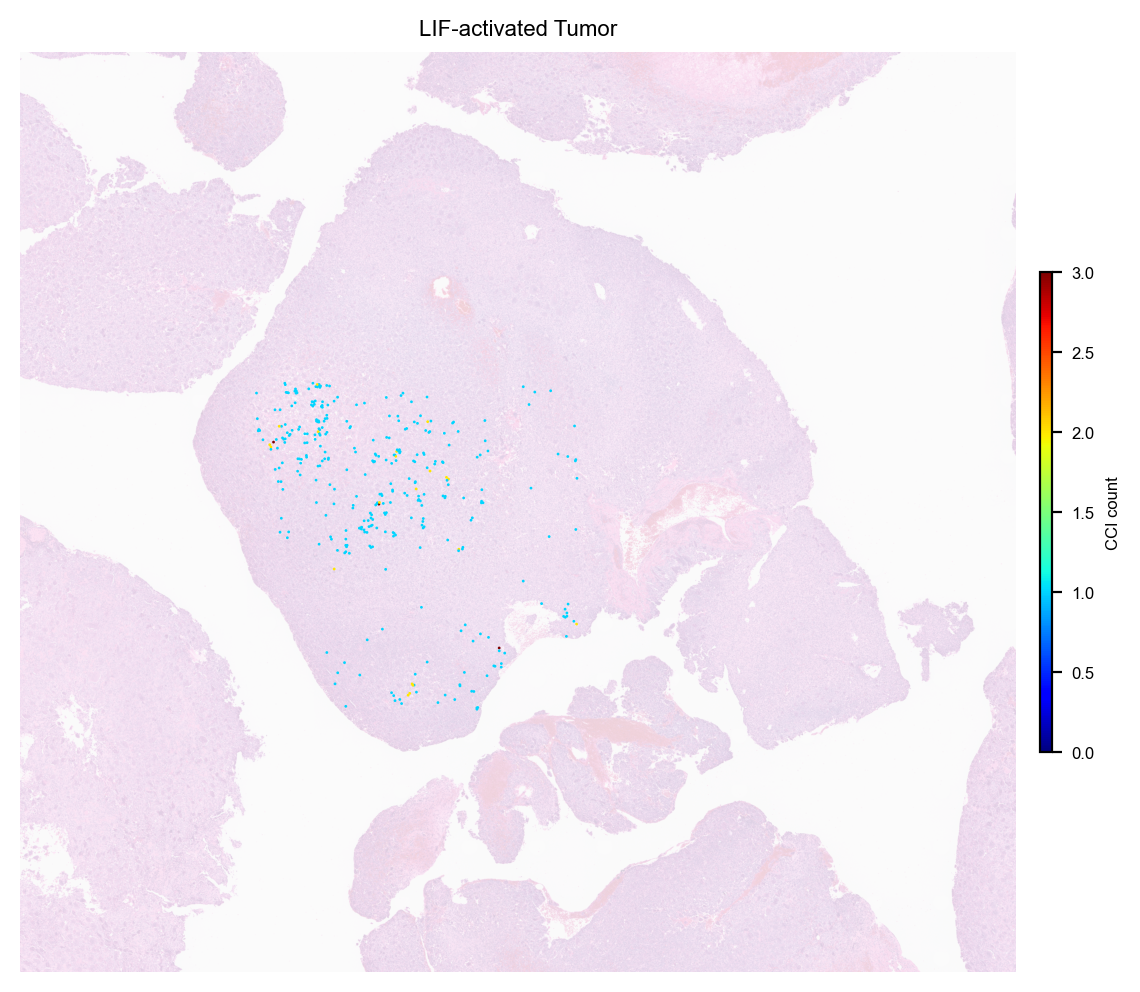

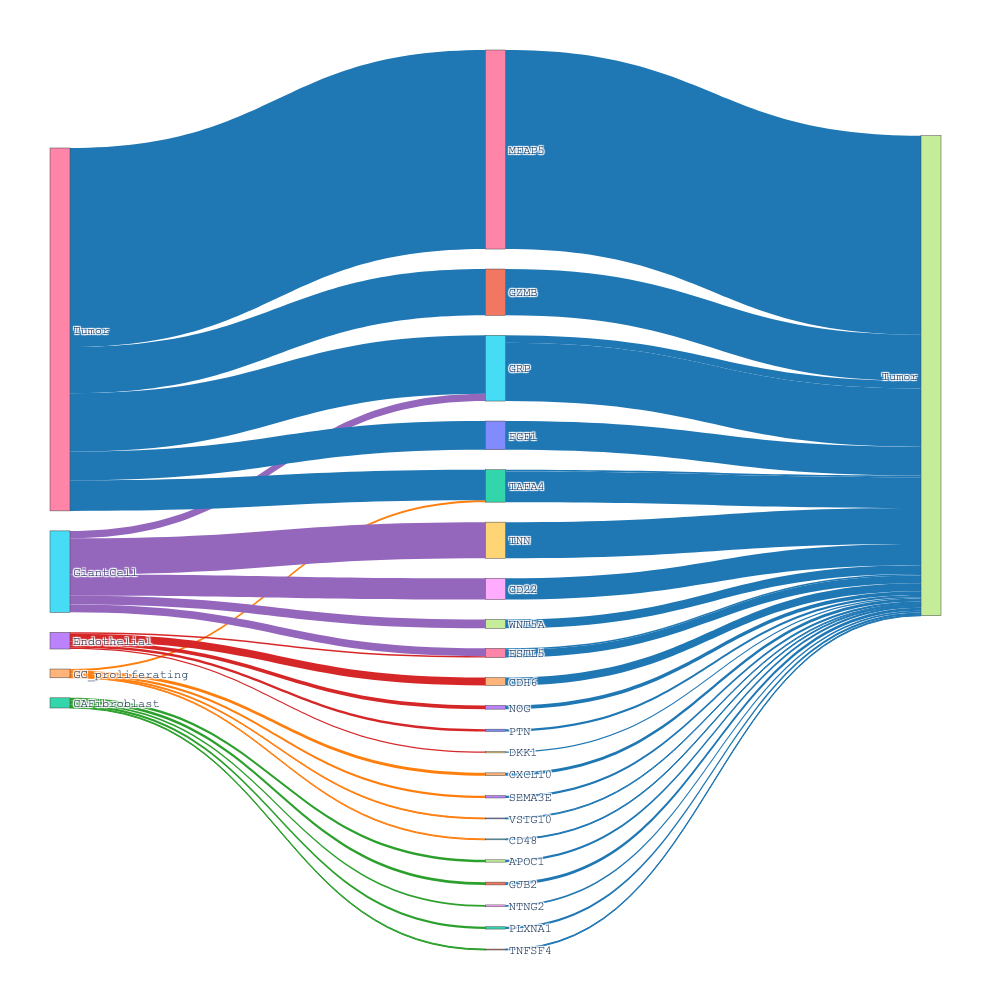

In [7]:
# Visualize
huetracer.plot_gene_cci_and_sankey(
    target_cell_type=target_cell_type,
    Gene_to_analyze=Gene_to_analyze,
    each_display_num=each_display_num,
    bargraph_df=bargraph_df,
    edge_df=edge_df,
    cluster_cells=cluster_cells,
    coexp_cc_df=coexp_cc_df,
    lib_id=lib_id,
    save=True,
    SAMPLE_NAME=SAMPLE_NAME,
    save_path_for_today=save_path_for_today
)